In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pywt

In [2]:
def wtt_filter(input_vector, d, modes, ranks=None, eps=None, check_correctness=False):
    assert ranks is not None or eps is not None
    
    filters = []
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(modes) == d
        if ranks is not None:
            assert len(ranks) == d - 1
        if eps is not None:
            assert 0 <= eps <= 1
        assert prod_modes == np.prod(modes)
        
    true_ranks = []
    
    r_prev = 1
    A = input_vector
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        if A.shape[0] <= A.shape[1]:
            u, sigmas, vt = np.linalg.svd(A, full_matrices=False)
        else:
            u, sigmas, vt = np.linalg.svd(A, full_matrices=True)
            
        r_given = None if ranks is None else (1 if k == d - 1 else ranks[k])
        r_eps = None if eps is None else max(1, (sigmas >= eps * sigmas[0]).sum())
        if r_given is not None and r_eps is not None:
            r_cur = min(r_given, r_eps)
        elif r_given is not None:
            r_cur = r_given
        else:
            r_cur = r_eps
        
        filters.append(u)

        if check_correctness:
            assert u.shape[0] == u.shape[1] == r_prev * modes[k]
            if k < d - 1:
                assert r_cur <= r_prev * modes[k]

        if k < d - 1:
            A = (u.T @ A)[:r_cur,:]
            prod_modes //= modes[k]
            true_ranks.append(r_cur)
            r_prev = r_cur
    
    return filters, true_ranks

def wtt_apply(input_vector, d, filters, modes, ranks, check_correctness=False):
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(filters) == d
        assert len(modes) == d
        assert len(ranks) == d - 1
        assert prod_modes == np.prod(modes)
        
    tails = []
    A = input_vector
    r_prev = 1
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        A = filters[k].T @ A

        if check_correctness:
            assert A.shape[0] == r_prev * modes[k]
            if k < d - 1:
                assert ranks[k] <= r_prev * modes[k]
                
        if k < d - 1:
            tails.append(A[ranks[k]:,:])
            A = A[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
        
    result = A
    for k in range(d - 2, -1, -1):        
        result = np.vstack([
            result.reshape((ranks[k], prod_modes), order='F'),
            tails[k]
        ])
        prod_modes *= modes[k]
    
    return result.flatten(order='F')

def iwtt_apply(input_vector, d, filters, modes, ranks, check_correctness=False):
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(filters) == d
        assert len(modes) == d
        assert len(ranks) == d - 1
        assert prod_modes == np.prod(modes)
        
    tails = []
    A = input_vector
    r_prev = 1
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')

        if check_correctness:
            assert A.shape[0] == r_prev * modes[k]
            if k < d - 1:
                assert ranks[k] <= r_prev * modes[k]
                
        if k < d - 1:
            tails.append(A[ranks[k]:,:])
            A = A[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
        
    #prod_modes == modes[-1] в конце
    result = A
    for k in range(d - 1, -1, -1):
        
        r_prev = 1 if k == 0 else ranks[k - 1]
        if k == d - 1:
            result = (filters[k] @ result).reshape((r_prev, prod_modes), order='F')
        else:
            result = (filters[k] @ np.vstack([
                result,
                tails[k]
            ])).reshape((r_prev, prod_modes), order='F')
        prod_modes *= modes[k]
    
    return result.flatten(order='F')

def matrix_to_vector(A, d, modes, check_correctness=False):
    if check_correctness is True:
        assert A.shape[0] == A.shape[1] == np.prod(modes)
        assert len(modes) == d
    result = np.reshape(A, modes + modes, order='F')
    axes_transpose = []
    for i in range(d):
        axes_transpose.append(i)
        axes_transpose.append(d + i)
    result = np.transpose(result, axes_transpose)
    new_modes = [m ** 2 for m in modes]
    result = np.reshape(result, new_modes, order='F')
    return result.flatten(order='F'), new_modes

def vector_to_matrix(v, d, modes, check_correctness=False):
    if check_correctness is True:
        assert v.size == np.prod(modes)
        assert len(modes) == d
    new_modes = [int(np.sqrt(m)) for m in modes]
    if check_correctness is True:
        assert np.all(modes == np.square(new_modes))
    result = np.reshape(v, new_modes + new_modes, order='F')
    axes_transpose = []
    for i in range(d):
        axes_transpose.append(2 * i)
    for i in range(d):
        axes_transpose.append(2 * i + 1)
    result = np.transpose(result, axes_transpose)
    result = np.reshape(result, (np.prod(new_modes), np.prod(new_modes)), order='F')
    return result, new_modes

def get_vector_modes(modes):
    return [m ** 2 for m in modes]

In [3]:
# %load robust-pca/r_pca.py
from __future__ import division, print_function

import numpy as np

try:
    from pylab import plt
except ImportError:
    print('Unable to import pylab. R_pca.plot_fit() will not work.')

try:
    # Python 2: 'xrange' is the iterative version
    range = xrange
except NameError:
    # Python 3: 'range' is iterative - no need for 'xrange'
    pass


class R_pca:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * np.linalg.norm(self.D, ord=1))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def frobenius_norm(M):
        return np.linalg.norm(M, ord='fro')

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.frobenius_norm(self.D)

        #this loop implements the principal component pursuit (PCP) algorithm
        #located in the table on page 29 of https://arxiv.org/pdf/0912.3599.pdf
        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)                            #this line implements step 3
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)             #this line implements step 4
            Yk = Yk + self.mu * (self.D - Lk - Sk)                                      #this line implements step 5
            err = self.frobenius_norm(self.D - Lk - Sk)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in range(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            if not axis_on:
                plt.axis('off')


In [4]:
import scipy.sparse

def wtt_rpca_v2(
    input_vector,
    d,
    modes,
    ranks=None,
    eps=None,
    lambda_scale=1.0,
    verbose=True,
    check_correctness=False
):
    assert ranks is not None or eps is not None
    
    filters = []
    sparse_parts = []
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(modes) == d
        if ranks is not None:
            assert len(ranks) == d - 1
        if eps is not None:
            assert 0 <= eps <= 1
        assert prod_modes == np.prod(modes)
        
    true_ranks = []
    
    r_prev = 1
    A = input_vector
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        
        #делаем разложение A = L + S, L --- малоранговая, S --- разреженная
        #затем: L = U Sigma V^T --- SVD для L. Ненулевых сингулярных чисел будет мало (надеемся)
        #U^T A = Sigma V^T + U^T S. Старшие строки оставляем для дальнейшей работы.
        #Надеемся, что младшие строки U^T S тоже будут разреженными...
        
        rpca = R_pca(A) 
        
        rpca.lmbda = rpca.lmbda * lambda_scale #делаю уклон в сторону sparse'овости
        
        if verbose:
            print("Step", k, "out of", d)
        
        L, S = rpca.fit(
            max_iter=4000,
            iter_print=400,
            verbose=verbose
        )
        
        if A.shape[0] <= A.shape[1]:
            u, sigmas, vt = np.linalg.svd(L, full_matrices=False)
        else:
            u, sigmas, vt = np.linalg.svd(L, full_matrices=True)
            
        r_given = None if ranks is None else (1 if k == d - 1 else ranks[k])
        r_eps = None if eps is None else max(1, (sigmas > eps * sigmas[0]).sum())
        if r_given is not None and r_eps is not None:
            r_cur = min(r_given, r_eps)
        elif r_given is not None:
            r_cur = r_given
        else:
            r_cur = r_eps
        
        filters.append(u)
        sparse_parts.append(scipy.sparse.csr_matrix(S))
        #скорее всего, строк меньше, чем столбцов, так что csr
        
        if verbose:
            print(
                "Low-rank check:",
                "r_cur = ", r_cur,
                "\n#singular values = ", sigmas.size,
                "\n#nnz singlular values = ", (sigmas > 1e-10).sum(),
                sep=''
            )
            print(
                "Sparsity check:",
                "S.size = ", S.size,
                "\nnnz(S) = ", np.count_nonzero(S), #можно так, поскольку S-часть по-честному разреженная
                #"\nnnz(u.T @ S) = ", np.count_nonzero(u.T @ S),
                sep=''
            )

        if check_correctness:
            assert u.shape[0] == u.shape[1] == r_prev * modes[k]
            if k < d - 1:
                assert r_cur <= r_prev * modes[k]

        if k < d - 1:
            A = (u.T @ L)[:r_cur,:]
            prod_modes //= modes[k]
            true_ranks.append(r_cur)
            r_prev = r_cur
    
    return filters, sparse_parts, true_ranks

def wtt_apply_rpca(input_vector, d, filters, sparse_parts, modes, ranks, check_correctness=False):
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(filters) == d
        assert len(sparse_parts) == d
        assert len(modes) == d
        assert len(ranks) == d - 1
        assert prod_modes == np.prod(modes)
        
    tails = []
    A = input_vector
    r_prev = 1
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        A = np.asarray(A - sparse_parts[k])
        A = filters[k].T @ A

        if check_correctness:
            assert A.shape[0] == r_prev * modes[k]
            if k < d - 1:
                assert ranks[k] <= r_prev * modes[k]
                
        if k < d - 1:
            tails.append(A[ranks[k]:,:])
            A = A[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
        
    result = A
    for k in range(d - 2, -1, -1):        
        result = np.vstack([
            result.reshape((ranks[k], prod_modes), order='F'),
            tails[k]
        ])
        prod_modes *= modes[k]
    
    return result.flatten(order='F')

def iwtt_apply_rpca(input_vector, d, filters, sparse_parts, modes, ranks, check_correctness=False):
    prod_modes = input_vector.size
    
    if check_correctness:
        assert len(filters) == d
        assert len(sparse_parts) == d
        assert len(modes) == d
        assert len(ranks) == d - 1
        assert prod_modes == np.prod(modes)
        
    tails = []
    A = input_vector
    r_prev = 1
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')

        if check_correctness:
            assert A.shape[0] == r_prev * modes[k]
            if k < d - 1:
                assert ranks[k] <= r_prev * modes[k]
                
        if k < d - 1:
            tails.append(A[ranks[k]:,:])
            A = A[:ranks[k],:]
            prod_modes //= modes[k]
            r_prev = ranks[k]
        
    #prod_modes == modes[-1] в конце
    result = A
    for k in range(d - 1, -1, -1):
        r_prev = 1 if k == 0 else ranks[k - 1]
        if k == d - 1:
            result = (filters[k] @ result)
        else:
            result = (filters[k] @ np.vstack([
                result,
                tails[k]
            ]))
        result = np.asarray(result + sparse_parts[k])
        result = result.reshape((r_prev, prod_modes), order='F')
        prod_modes *= modes[k]
    
    return result.flatten(order='F')

In [5]:
class WTTwrapper:
    def __init__(self):
        self.d = None
        self.modes = []
        self.filters = []
        self.ranks = []
    
    def adjust(self, input_data, d, modes, ranks=None, eps=None, is_2D=False):        
        if is_2D is True:
            data, vector_modes = matrix_to_vector(input_data, d, modes, True)
        else:
            data, vector_modes = input_data, modes
        
        filters, ranks = wtt_filter(data, d, vector_modes, ranks, eps, True)
        self.d = d
        self.modes = modes
        self.filters = filters
        self.ranks = ranks
        
    def apply(self, input_data, is_2D=False):
        if is_2D is True:
            data, vector_modes = matrix_to_vector(input_data, d, self.modes, True)
        else:
            data, vector_modes = input_data, self.modes
        wtt_result = wtt_apply(data, self.d, self.filters, vector_modes, self.ranks, True)
        return wtt_result
    
    def apply_inverse(self, input_data, is_2D=False):
        vector_modes = self.modes if is_2D is False else get_vector_modes(self.modes)
        iwtt_result = iwtt_apply(input_data, self.d, self.filters, vector_modes, self.ranks, True)
        if is_2D is True:
            iwtt_result, _ = vector_to_matrix(iwtt_result, d, vector_modes, True)
        return iwtt_result

In [6]:
class WTTRPCAwrapper:
    def __init__(self):
        self.d = None
        self.modes = []
        self.filters = []
        self.ranks = []
        self.sparse_parts = []
    
    def adjust(self, input_data, d, modes, ranks=None, eps=None, lambda_scale=1, is_2D=False):        
        if is_2D is True:
            data, vector_modes = matrix_to_vector(input_data, d, modes, True)
        else:
            data, vector_modes = input_data, modes
        
        filters, sparse_parts, ranks = wtt_filter(data, d, vector_modes, ranks, eps, lambda_scale, False, True)
        self.d = d
        self.modes = modes
        self.filters = filters
        self.ranks = ranks
        self.sparse_parts = sparse_parts
        
    def apply(self, input_data, is_2D=False):
        if is_2D is True:
            data, vector_modes = matrix_to_vector(input_data, d, self.modes, True)
        else:
            data, vector_modes = input_data, self.modes
        wtt_result = wtt_apply_rpca(data, self.d, self.filters, self.sparse_parts, vector_modes, self.ranks, True)
        return wtt_result
    
    def apply_inverse(self, input_data, is_2D=False):
        vector_modes = self.modes if is_2D is False else get_vector_modes(self.modes)
        iwtt_result = iwtt_apply_rpca(input_data, self.d, self.filters, self.sparse_parts, vector_modes, self.ranks, True)
        if is_2D is True:
            iwtt_result, _ = vector_to_matrix(iwtt_result, d, vector_modes, True)
        return iwtt_result

In [111]:
original = pywt.data.camera()
original.shape

(512, 512)

In [112]:
original = original / 255.

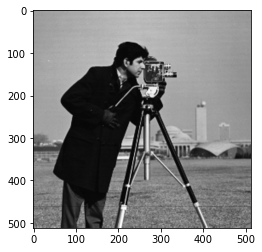

In [113]:
plt.imshow(original, cmap='gray')

In [114]:
d = 9
modes = [2] * d

epsilons = [1e-1, 1e-2, 1e-3, 1e-4]
wtts = [WTTwrapper() for _ in range(len(epsilons))]
db_names = ['db1', 'db2', 'db3', 'db4']
dbs = [pywt.Wavelet(name) for name in db_names]

for W, eps in zip(wtts, epsilons):
    W.adjust(original, d, modes, eps=eps, is_2D=True)

In [115]:
[W.ranks for W in wtts]

[[1, 1, 1, 2, 2, 2, 3, 3],
 [3, 7, 15, 31, 46, 35, 14, 4],
 [4, 13, 28, 81, 146, 64, 16, 4],
 [4, 16, 64, 186, 256, 64, 16, 4]]

In [116]:
deltas = np.logspace(-6,-1,num=20)
deltas

array([1.00000000e-06, 1.83298071e-06, 3.35981829e-06, 6.15848211e-06,
       1.12883789e-05, 2.06913808e-05, 3.79269019e-05, 6.95192796e-05,
       1.27427499e-04, 2.33572147e-04, 4.28133240e-04, 7.84759970e-04,
       1.43844989e-03, 2.63665090e-03, 4.83293024e-03, 8.85866790e-03,
       1.62377674e-02, 2.97635144e-02, 5.45559478e-02, 1.00000000e-01])

In [117]:
wtt_errors = [[] for _ in range(len(wtts))]
db_errors = [[] for _ in range(len(dbs))]

for i in range(len(wtts)):
    W = wtts[i]
    eps = epsilons[i]
    coeffs = W.apply(original, is_2D=True)
    print("Analyzing WTT with eps=", eps)
    for delta in deltas:
        #print("delta=", delta)
        #print((np.abs(coeffs) < delta).sum())
        compr = coeffs.copy()
        compr[np.abs(compr) < delta] = 0
        img_restored = W.apply_inverse(compr, is_2D=True)
        rel_error = np.linalg.norm(original - img_restored) / np.linalg.norm(original)
        wtt_errors[i].append(rel_error)

Analyzing WTT with eps= 0.1
Analyzing WTT with eps= 0.01
Analyzing WTT with eps= 0.001
Analyzing WTT with eps= 0.0001


In [118]:
for i in range(len(dbs)):
    db = dbs[i]
    coeffs = pywt.wavedec2(original, db)
    print("Analyzing Daubechies wavelet", db_names[i])
    for delta in deltas:
        #print("delta=", delta)
        #print((np.abs(coeffs) < delta).sum())
        compr = []
        for c in coeffs:
            if isinstance(c, tuple):
                c1, c2, c3 = c
                c4 = c1.copy()
                c4[np.abs(c4) < delta] = 0
                c5 = c2.copy()
                c5[np.abs(c5) < delta] = 0
                c6 = c3.copy()
                c6[np.abs(c6) < delta] = 0
                cc = (c4, c5, c6)
            else:
                cc = c.copy()
                cc[np.abs(cc) < delta] = 0
            compr.append(cc)
        img_restored = pywt.waverec2(compr, db)
        rel_error = np.linalg.norm(original - img_restored) / np.linalg.norm(original)
        db_errors[i].append(rel_error)

Analyzing Daubechies wavelet db1
Analyzing Daubechies wavelet db2
Analyzing Daubechies wavelet db3
Analyzing Daubechies wavelet db4


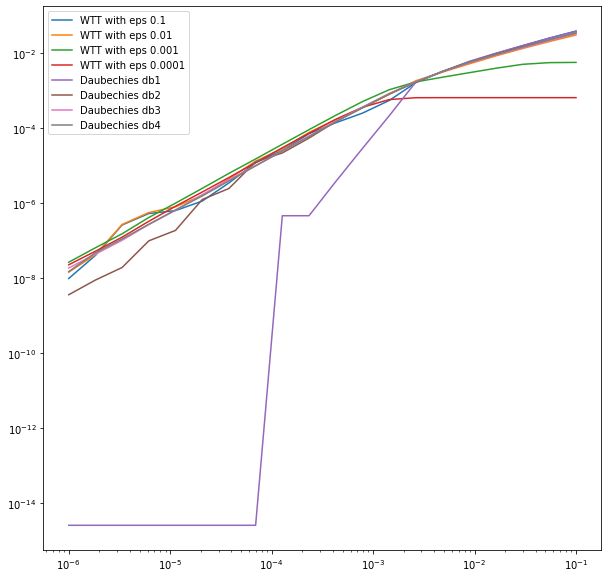

In [133]:
plt.figure(figsize=(10,10))
plt.xscale('log')
plt.yscale('log')
for i in range(4):
    plt.plot(deltas, wtt_errors[i], label="WTT with eps " + str(epsilons[i]))
for i in range(4):
    plt.plot(deltas, db_errors[i], label="Daubechies " + db_names[i])
plt.legend()

plt.savefig('f1.png')

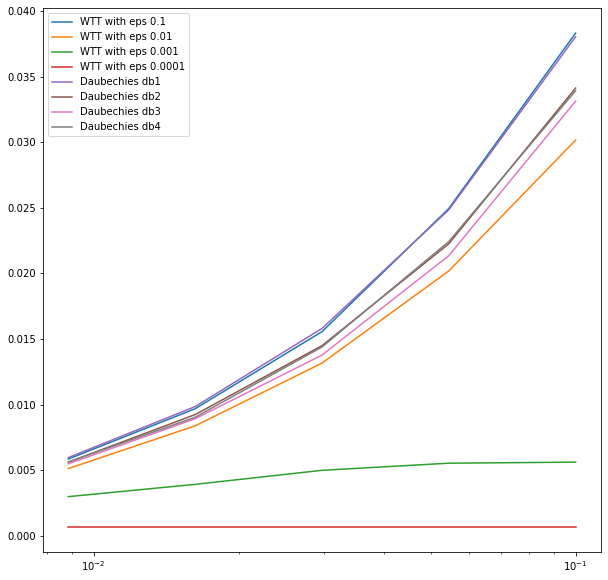

In [134]:
plt.figure(figsize=(10,10))
plt.xscale('log')
for i in range(4):
    plt.plot(deltas[15:], wtt_errors[i][15:], label="WTT with eps " + str(epsilons[i]))
for i in range(4):
    plt.plot(deltas[15:], db_errors[i][15:], label="Daubechies " + db_names[i])
plt.legend()

plt.savefig('f2.png')

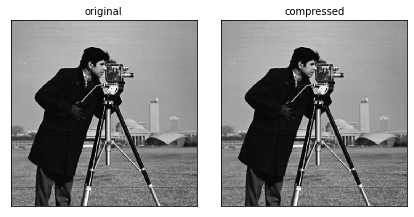

In [84]:
fig = plt.figure(figsize=(6, 3))
titles = ["original", "compressed"]
for i, a in enumerate([original, img_compressed]):
    ax = fig.add_subplot(1, 2, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [89]:
np.linalg.norm(original - img_compressed) / np.linalg.norm(original)

0.001223003329284175

In [129]:
import matplotlib

matplotlib.image.imsave('cameraman.png', original, cmap='gray')